# Tag similarities

The analysis of this notebook makes use of last.fm data to find structures in musical collaborative tagging. <br>
This notebook __must__ be in the same directory than the last.fm data.
* [Finding pairwise similarities using correlation](#corr)
* [Finding clusters of tags using K-means on bag of words](#cluster)

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Construct dictionaries to map integer IDs of artist/tag to their actual string values.

In [2]:
tags = pd.read_csv('tags.dat', sep='\t', encoding = 'ISO-8859-1')
zipList = zip(tags.tagID.to_list(), tags.tagValue.to_list())
dictOfTags = dict(zipList)

In [3]:
artists = pd.read_csv('artists.dat', sep='\t')
zipList = zip(artists.id.to_list(), artists.name.to_list())
dictOfArtists = dict(zipList)

### Finding pairwise similarities using correlation <a class="anchor" id="corr"></a>

Use the 500 most popular tags.

In [4]:
nTags = 500
userTagArtist = pd.read_csv('user_taggedartists.dat', sep='\t')
sorted_tags = userTagArtist['tagID'].value_counts()
firstTags = sorted_tags.head(nTags).index.to_list()

Construct correlation between the tags, from occurences in artist tags.

In [5]:
artistTagMatrix = userTagArtist[['artistID','tagID']].groupby(['artistID','tagID']).size().unstack()
artistTagMatrix = artistTagMatrix[firstTags].fillna(0)
tagCorr = artistTagMatrix.corr()

Extract all correlations and make an histogram. <br>
Some tags are highly correlated but never anti-correlated, i.e. there are very similar tags but no "dissimilar" tags.

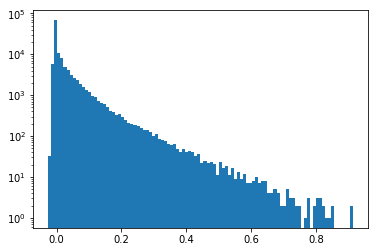

In [6]:
ilower = np.tril_indices(nTags, -1)
plt.hist(np.asarray(tagCorr)[ilower], bins=100, log=True);

Show the 60 most similar tags (according to linear correlation). <br>
The `drop(index=...)` is used to ignore the diagonal of the correlation matrix (value 1).

In [7]:
corrStack = tagCorr.stack()
top = corrStack.drop(index=corrStack[corrStack.eq(1)].index).sort_values(ascending=False)
top.rename(dictOfTags).drop_duplicates().head(60)

tagID                 tagID               
korean                k-pop                   0.913729
glam metal            hair metal              0.910982
legend                britney spears          0.856611
hip-hop               rap                     0.849267
fantastic             cool as                 0.846452
psytrance             goa                     0.832268
hip-hop               hip hop                 0.826660
great song            my favorite             0.822234
psychedelic trance    psytrance               0.818196
indie                 indie rock              0.818128
screamo               post-hardcore           0.812301
hip hop               rap                     0.808087
punk rock             punk                    0.804103
goa                   psychedelic trance      0.802050
alternative           alternative rock        0.796345
jamaica               jamaican                0.792955
synthpop              synth pop               0.781788
pop                   

## Finding clusters of tags using K-means on bag of words <a class="anchor" id="cluster"></a>

Construct the bag of words.

In [9]:
bag_of_words = userTagArtist[['artistID','tagID']].groupby(['artistID','tagID']).size().unstack()
bag_of_words = bag_of_words[firstTags]
bag_of_words.rename(dictOfTags,   axis=1, inplace=True)
bag_of_words.rename(dictOfArtists, axis=0, inplace=True)
bag_of_words[bag_of_words.notnull()] = 1
bag_of_words.fillna(0, inplace=True)

Apply K-means on the bag of words (not finely tuned yet). <br>
Since the objctive function of K-means is not convex, the result depends on the random initial state. K-means should be run several times in order to find the most probable clustering.

In [198]:
kmeans = KMeans(n_clusters=100).fit(np.asarray(bag_of_words).T)

Show the clusters containing more than 4 tags (and not too many tags).

In [200]:
tagList = np.asarray(bag_of_words.columns)
clusters = np.arange(100)
clusterInd = np.logical_and(np.bincount(kmeans.labels_) > 3, np.bincount(kmeans.labels_) < 30)
for cluster in clusters[clusterInd]:
    print(tagList[kmeans.labels_ == cluster])

['classic' 'sweet' 'gangsta rap' 'nice' 'smooth' 'hard' 'good shit' 'dope'
 'crazy' 'sick' 'phat' 'tight' 'the good stuff' 'the truth' 'real talk']
['rnb' 'urban' '2008' 'top 40' 'madonna' 'beyonce' 'justin timberlake'
 'r and b' 'nelly furtado' 'harmonies']
['electropop' 'indietronica' 'new rave' 'neon space']
['<3' 'love at first listen' 'catchy' 'fun' 'happy' 'remix' 'english'
 'hot' 'party' 'guilty pleasure' 'cute' 'diva' '2010' 'addictive'
 'electro pop' "let's dance"]
['sad' 'epic' 'atmospheric' 'romantic' 'favorite songs' 'melancholic'
 'perfect' 'love it' 'fucking awesome' 'brilliant' 'lovely' 'genius']
['lounge' 'chill' 'dreamy' 'relax' 'vocal']
['new age' 'relaxing' 'ethereal' 'christmas' 'irish' 'celtic']
['brazilian' 'brasil' 'mpb' 'brazil']
['synth pop' 'new romantic' 'fav artists' 'fav songs' 'british artists'
 'new wave artists']
['country' 'love songs' 'memories' 'great song' 'classic country'
 'my favorite']
['trance' 'psytrance' 'progressive trance' 'psychedelic tranc